In [1]:
%matplotlib notebook 

import numpy
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
numpy.random.seed(1234)

In [4]:
# data set generation
n_dim = 2

n_mean1 = numpy.array([-1., -1.])
n_cov1 = numpy.diag([0.5, .5])
n_mean2 = numpy.array([1., 1.])
n_cov2 = numpy.diag([0.5, .5])

p_mean1 = numpy.array([-1., 1.])
p_cov1 = numpy.diag([.5, .5])
p_mean2 = numpy.array([1., -1.])
p_cov2 = numpy.diag([.5, .5])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos * 2) 
pos_x = numpy.concatenate([numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov1)[None, :] + p_mean1[None,:],
                           numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov2)[None, :] + p_mean2[None,:]])
n_pos *= 2
# generate negative examples
n_neg = 50
neg_y = numpy.zeros(n_neg * 2) 
neg_x = numpy.concatenate([numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov1)[None, :] + n_mean1[None,:],
                           numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov2)[None, :] + n_mean2[None,:]])
n_neg *= 2
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = numpy.random.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int)

y_tra = y[:n_tra]
x_tra = x[:n_tra]

y_tes = y[n_tra:]
x_tes = x[n_tra:]

In [5]:
def perceptron(x, w, pre=False):
    def sign(y):
        return numpy.maximum(0., numpy.sign(y))
    
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sign(y)

In [6]:
def perceptron_dist(y, x, w, avg=False):
    y_ = perceptron(x, w)
    d = -(y - y_) * perceptron(x, w, pre=True)
    if not avg:
        return d
    return numpy.mean(d)

In [7]:
def perceptron_rule(y, x, w):
    y_ = perceptron(x, w)
    dw = numpy.zeros(w.shape)
    dw[:-1] = numpy.mean((y_tra - y_)[:, None] * x, axis=0)
    dw[-1] = numpy.mean(y_tra - pred_y)
    return dw

In [8]:
w0 = numpy.random.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

n_iter = 1000
eta = .1
old_cost = numpy.Inf
for ni in xrange(n_iter):
    pred_y = perceptron(x_tra, w)
    w += eta * perceptron_rule(y_tra, x_tra, w)
    cost = perceptron_dist(y_tra, x_tra, w, avg=True)
    if numpy.mod(ni, 50) == 0:
        print 'Perceptron cost {} after iteration {}'.format(cost, ni)
    if cost < 1e-16 or cost / old_cost >= 1.:
        print 'Converged'
        break
    old_cost = cost

Perceptron cost 0.753327970428 after iteration 0
Converged


In [9]:
# visualize data 
def vis_data(x, y, c='r'):
    plot.hold('on')
    for x_, y_ in zip(x, y):
        plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [10]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


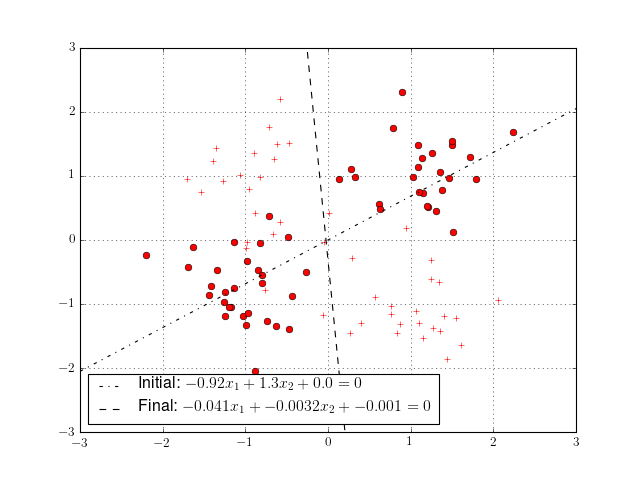

In [11]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
#vis_data(x_tes, y_tes, c='b')

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w))],
           loc='best')

plot.show()

In [12]:
plot.savefig('../figures/perceptron_failure.pdf', dpi=100)

In [12]:
tra_er = numpy.sum(numpy.abs(perceptron(x_tra, w) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(perceptron(x_tes, w) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.52, Test error rate 0.46
